<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Getting Started with QISKit*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Jay Gambetta, Ismael Faro, Andrew Cross, Ali Javadi

## QISKit (Quantum Information Software developer Kit)

This tutorial aims to explain how to use QISKit. We assume you have installed QISKit if not please look at [qiskit.org](http://www.qiskit.org) or the install [documentation](../INSTALL.md). 

QISKit is a Python software development kit that you can use to create your quantum computing programs based on circuits defined through the [OpenQASM 2.0](https://github.com/QISKit/qiskit-openqasm) specification, compile them, and execute them on several backends (real quantum processors online, simulators online, and simulators on local). For the online backends conects to the [IBM Q experience project](http://quantumexperience.ng.bluemix.net/).

In addition to this tutorial, we have other tutorials that introduce you to more complex concepts directly related to quantum computing.

More examples:
- Familiarize yourself with the important concepts of [superposition and entanglement](../qis/superposition_and_entanglement.ipynb).

## Basic Concept

The basic concept of our quantum program is an array of quantum circuits. The program workflow consists of three stages: [Build](#sectionB), [Compile](#sectionC), and [Run](#sectionR). Build allows you to make different quantum circuits that represent the problem you are solving; Compile allows you to rewrite them to run on different backends (simulators/real chips of different [quantum volumes](http://ibm.biz/qiskit-quantum-volume), sizes, fidelity, etc); and Run launches the jobs.  After the jobs have been run, the data is collected. There are methods for putting this data together, depending on the program. This either gives you the answer you wanted, or allows you to make a better program for the next instance.

### Building your program: Create it  <a id='sectionB'></a>

First you need to import the QuantumProgram package from QISKit.

In [78]:
# Checking the version of PYTHON; we only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
import qiskit

try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.url}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

The basic elements needed for your first program are the QuantumCircuit, QuantumRegister, and ClassicalRegister.

In [81]:
# Create a Quantum Register called "q" with 3 qubits
qr = qiskit.QuantumRegister("q", 3)

# Create a Classical Register called "c" with 3 bits
cr = qiskit.ClassicalRegister("c", 3)

# Create a Quantum Circuit called involving "qr" and "cr"
circuit = qiskit.QuantumCircuit(qr, cr)

### Building your program: Add Gates to your Circuit
After you create the circuit with its registers, you can add gates to manipulate the registers. As you proceed though the tutorial you will find more quantum gates and circuits but the below is an example of the quantum half adder.

In [82]:
# Not gate on qubit 0
circuit.x(qr[0])

# Not gate on qubit 1
circuit.x(qr[1])

# Barrier to seperator the input from the circuit
circuit.barrier(qr)

# Toffoli gate from qubit 0,1 to qubit 2
circuit.ccx(qr[0], qr[1], qr[2])

# CNOT (Controlled-NOT) gate from qubit 0 to qubit 1
circuit.cx(qr[0], qr[1])

# measure gate from qr to cr
circuit.measure(qr, cr)

### Extract OpenQASM

You can obtain a OpenQASM representation of your code.

In [83]:
# QASM from a program

QASM_source = circuit.qasm()

print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[3];
x q[0];
x q[1];
barrier q[0],q[1],q[2];
ccx q[0],q[1],q[2];
cx q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];



### Visualize Circuit

You can visualize your circuit using QISKit's `circuit_drawer`, which plots the unrolled circuit in the specified basis.

NOTE: To get this to work you need to make sure poppler is installed.

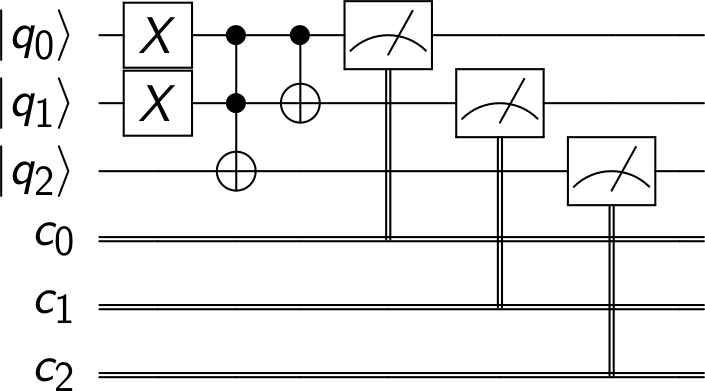

In [84]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(circuit)

### Compile and Run or Execute <a id='sectionC'></a>

In [61]:
# Create a Quantum Program for execution 
qp = qiskit.QuantumProgram()
# Add the circuit you created to it, and call it the "bell" circuit.
# (You can add multiple circuits to the same program, for batch execution)
qp.add_circuit("Circuit", circuit)

First we need to choose the backend. Lets start with the local simulator 

In [62]:
local_backends = qiskit.backends.discover_local_backends()
print("(Local Backends)")
for backend in local_backends:
    print(backend)

(Local Backends)
local_qasm_simulator
local_unitary_simulator


In [63]:
backend = 'local_qasm_simulator' 
circuits = ['Circuit']  # Group of circuits to execute

Next we need to compile the circuits into a quantum object which we call qobj

In [64]:
qobj=qp.compile(circuits, backend) # Compile your program

Then you can run your program. Using wait and timeout we can check the execution result every 2 seconds and timeout if the job is not run in 240 seconds. 

In [65]:
result = qp.run(qobj, wait=2, timeout=240)
print(result)

COMPLETED


When you run a program, the result will be a new object that contains the data, status, and a copy of the qobj. The status of the results can be obtained using print and will one of the follow:

```
JOB_STATUS = {
    inProgress: 'RUNNING',
    errorOnCreate: 'ERROR_CREATING_JOB',
    errorExecuting: 'ERROR_RUNNING_JOB',
    completed: 'COMPLETED'
  };
``` 

### Result
You can access the result via the function 

```get_counts('name')```. 

In [66]:
result.get_counts('Circuit')

{'101': 1024}

In addition to getting the number of times each output was seen, you can get the circuit which was run in QASM format.
For this simulation, the compiled circuit is not much different from the input circuit. Each single-qubit gate has been expressed as a u1, u2, or u3 gate.

In [67]:
ran_qasm = result.get_ran_qasm('Circuit')

print(ran_qasm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[3];
u3(3.14159265358979,0,3.14159265358979) q[0];
u3(3.14159265358979,0,3.14159265358979) q[1];
barrier q[0],q[1],q[2];
u2(0,3.14159265358979) q[2];
cx q[1],q[2];
u1(-0.785398163397448) q[2];
cx q[0],q[2];
u1(0.785398163397448) q[2];
cx q[1],q[2];
u1(-0.785398163397448) q[2];
cx q[0],q[2];
u1(0.785398163397448) q[1];
u1(0.785398163397448) q[2];
u2(0,3.14159265358979) q[2];
cx q[0],q[1];
u1(0.785398163397448) q[0];
u1(-0.785398163397448) q[1];
cx q[0],q[1];
cx q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];



You can use 

```qp.execute(circuits)```

to combine the compile and run in a single step.

In [68]:
out = qp.execute(circuits, backend, wait=2, timeout=240)
print(out)

COMPLETED


#### Compile Parameters
```qp.compile(name_of_circuits, backend='local_qasm_simulator', config=None, basis_gates=None, coupling_map=None, initial_layout=None, shots=1024, max_credits=10, seed=None, qobj_id=None, hpc=None)```

    - name_of_circuits (list[str]): circuit names to be compiled.
    - backend (str): a string representing the backend to compile to
    - config (dict): a dictionary of configurations parameters for the
        compiler
    - basis_gates (str): a comma seperated string and are the base gates,
                       which by default are provided by the backend
    - coupling_map (dict): A directed graph of coupling:
    - initial_layout (dict): A mapping of qubit to qubit:
    - shots (int): the number of shots 
    - max_credits (int): the max credits to use 3, or 5
    - seed (int): the intial seed the simulatros use
    - qobj_id (str): identifier of the qobj.
    - hpc (dict): This will setup some parameter for
                ibmqx_hpc_qasm_simulator, using a JSON-like format like:
#### Run Parameters
```qp.run(qobj, wait=5, timeout=60)```
     - qobj (dict): the dictionary of the quantum object to run.
     - wait (int): Time interval to wait between requests for results
     - timeout (int): Total time to wait until the execution stops     
#### Execute Parameters 
Execute has the combined parameters of compile and run.

```qp.execute(name_of_circuits, backend='local_qasm_simulator', config=None, wait=5, timeout=60, basis_gates=None, coupling_map=None, initial_layout=None, shots=1024, max_credits=3, seed=None, hpc=None)
```

(**Tip**: You can obtain the above parameters in Jupyter. Simply place the text cursor on a function and press Shift+Tab)

### Execute on a Real Device<a id='sectionR'></a>

In [69]:
from IBMQuantumExperience import IBMQuantumExperience
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

In [70]:
remote_backends = qiskit.backends.discover_remote_backends(api)
# see a list of available remote backends
print("\n(Remote Backends)")
for backend in remote_backends:
    backend_status = api.backend_status(backend)
    print(backend, backend_status)


(Remote Backends)
ibmqx2 {'available': False, 'busy': False, 'pending_jobs': 48, 'backend': 'ibmqx2'}
ibmqx5 {'available': True, 'busy': False, 'pending_jobs': 1, 'backend': 'ibmqx5'}
ibmqx4 {'available': True, 'busy': False, 'pending_jobs': 2, 'backend': 'ibmqx4'}
ibmqx_hpc_qasm_simulator {'backend': 'ibmqx_hpc_qasm_simulator'}
ibmqx_qasm_simulator {'available': False, 'busy': False, 'pending_jobs': 48, 'backend': 'ibmqx_qasm_simulator'}


In [71]:
backend = 'ibmqx4'  # Backend where you execute your program; in this case, on the real Quantum Chip online 
circuits = ['Circuit']   # Group of circuits to execute
shots = 1024           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3          # Maximum number of credits to spend on executions. 

result_real = qp.execute(circuits, backend=backend, shots=shots, max_credits=max_credits, wait=10, timeout=240)

In [72]:
qiskit.backends.get_backend_configuration('local_qasm_simulator')

{'basis_gates': 'u1,u2,u3,cx,id',
 'coupling_map': 'all-to-all',
 'description': 'A python simulator for qasm files',
 'local': True,
 'name': 'local_qasm_simulator',
 'simulator': True,
 'url': 'https://github.com/IBM/qiskit-sdk-py'}

Like before, the counts from the execution can be obtained using ```get_counts('name')``` 

In [73]:
result_real.get_counts('Circuit')

{'00000': 38,
 '00001': 43,
 '00010': 118,
 '00011': 88,
 '00100': 47,
 '00101': 19,
 '00110': 575,
 '00111': 96}

In [74]:
%run "../../version.ipynb"

Package,Version
QISKit,0.4.10
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
